In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from Demo_Params import BASESETUP

In [3]:
def getSTSNEDirByParams(setup,batch,slice_size,n_iter,min_dense,files):
    basedir = os.path.join("..","Results",setup,f"B{batch}_SL{slice_size}_IT{n_iter}_D{min_dense}")
    return {x:os.path.join(basedir, x + ".csv") for x in files}


def getTSNEDirByParams(setup,batch,slice_size,n_iter,min_dense,files):
    tsnePath = os.path.join("..","Results",setup,f"B{batch}_SL{slice_size}_TSNE")
    return {x:os.path.join(tsnePath,x + ".csv") for x in files}

In [4]:
def readCSV(setup,parameters, testType, fileNames, rescales, remove_initial=False, iteractive=True):
    batch,slice_size,_,(min_dense,_),(_,n_iterOpt) = parameters
    if iteractive:
        files = getSTSNEDirByParams(setup,batch,slice_size,n_iterOpt,min_dense,fileNames)
        algorithm_name = "S+TSNE"
        reference = f"B:{batch}, D:{min_dense}, Iter:{n_iterOpt}"
    else:
        files = getTSNEDirByParams(setup,batch,slice_size,n_iterOpt,min_dense,fileNames)
        algorithm_name = "TSNE"
        reference = f"B:{batch}"
    csvReads = []
    for fileType in files:
        newFile = pd.read_csv(files[fileType])
        newDF= newFile.stack().reset_index().drop("level_0",axis=1)
        newDF.columns = ["Points","Value"]
        newDF=newDF[newDF["Points"] != "0"]
        if remove_initial:
            newDF=newDF[newDF["Points"] != str(newDF["Points"].astype(int).min())]
        if fileType in rescales:
            newDF["Value"] = newDF["Value"]/rescales[fileType]           
        newDF["Analysis"] = displayNames[fileType]
        newDF["Category"] = testType
        newDF["Slice"] = slice_size
        newDF["Algorithm"] = algorithm_name
        newDF["Reference"] = reference
        csvReads.append(newDF)
    return pd.concat(csvReads)

In [5]:
def plot_algorithm_comparison(df,rowLabels,figName, height=3, aspect=1, markers=[".","."], dashes=[(1,0),(2,1)]):
    possibleColors = ["#B69F00", "#56B4E9", "#F2A590", "#F0E442", "#3333ff","#0072B2", "#D55E00", "#CC79A7", "#0b5c21","#2a9d8f","#ff6961",sns.color_palette("dark:salmon_r")[0]]
    possibleGray = list(sns.color_palette(palette='gist_gray'))
    palette = {x:possibleColors.pop(0) for x in df["Reference"].unique() if len(x) > 10} | {x:possibleGray.pop(0) for x in df["Reference"].unique() if not len(x) > 10}
    sns.set_theme()
    g = sns.FacetGrid(df,col="Slice",row="Analysis", sharey=False,legend_out=True, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot,x="Points",y="Value",hue="Reference",style="Algorithm", palette=palette, markers=markers, dashes=dashes)
    g.add_legend()
    for i, axes_row in enumerate(g.axes):
        for j, axes_col in enumerate(axes_row):
            row, col = axes_col.get_title().split('|')
            if i == 0:
                axes_col.set_title(col.strip())
            else:
                axes_col.set_title('')

            if j == 0:
                ylabel = axes_col.get_ylabel()
                axes_col.set_ylabel(rowLabels.pop(0))

    g.figure.subplots_adjust(wspace=0.2,hspace=0.05)
    return g.savefig(figName)

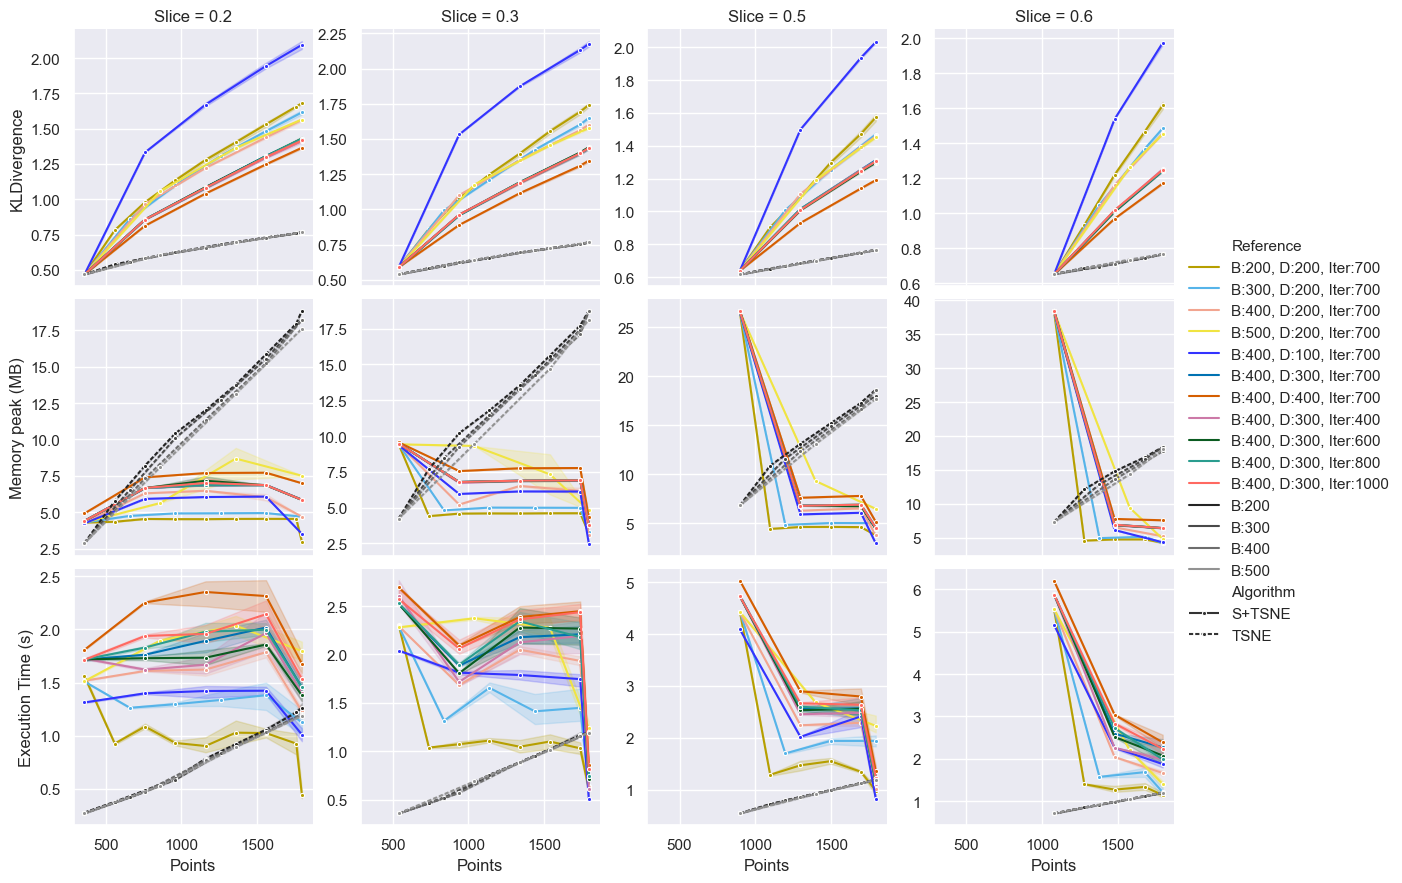

In [6]:
#MNIST
setup = "MNIST"
fileNames = ["KL_div","MemoryPeak","timer"]
displayNames = {"KL_div":"KL-Divergence","MemoryPeak":"Peak Memory Usage","timer":"Execution Time"}
rescales = {"MemoryPeak":10**6}

paramsToRead = {
    "BATCH": BASESETUP[setup][:16],
    "DENSITY": BASESETUP[setup][16:32],
    "ITER": BASESETUP[setup][32:48]
}
csvs = []
for testType in paramsToRead:
    for param in paramsToRead[testType]:
        csvs.append(readCSV(setup,param,testType,fileNames,rescales))
    
for testType in paramsToRead:
    for param in paramsToRead[testType]:
        csvs.append(readCSV(setup,param,testType,fileNames,rescales,iteractive=False))
        

df = pd.concat(csvs)
df.to_csv("MNIST_analysis.csv",index=False)
df = pd.read_csv("MNIST_analysis.csv")
rowLabels = ["KLDivergence", "Memory peak (MB)","Execution Time (s)"]
figName = "MNIST_analysis.png"
#display(df)
plot_algorithm_comparison(df,rowLabels,figName)


dict_keys(['MNIST', 'DRIFTED_500K'])


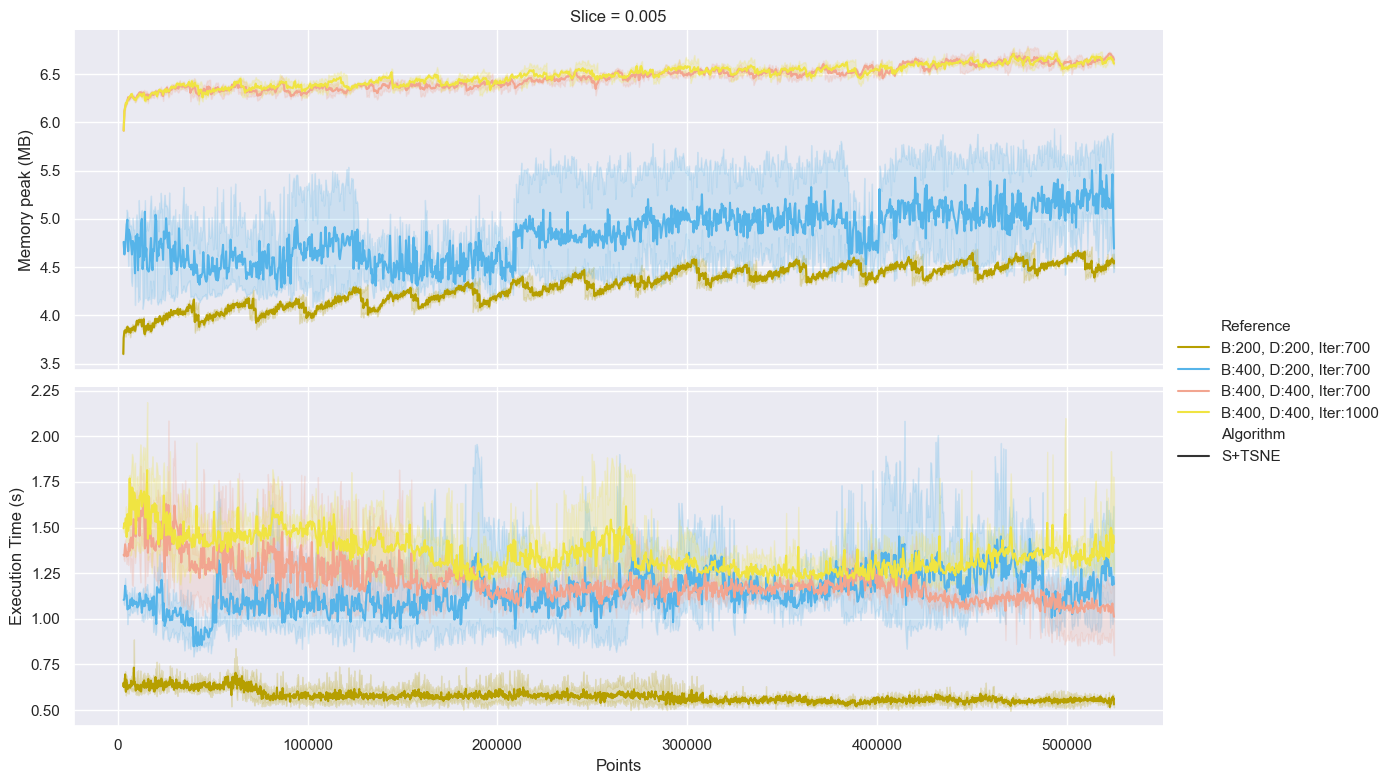

In [7]:
#DRIFTED_500k
setup = "DRIFTED_500K"
fileNames = ["MemoryPeak","timer"]
displayNames = {"KL_div":"KL-Divergence","MemoryPeak":"Peak Memory Usage","timer":"Execution Time"}
rescales = {"MemoryPeak":10**6}
print(BASESETUP.keys())

paramsToRead = {
    "DRIFT": BASESETUP[setup]
}
csvs = []
for testType in paramsToRead:
    for param in paramsToRead[testType]:
        csvs.append(readCSV(setup,param,testType,fileNames,rescales,remove_initial=True))        

df = pd.concat(csvs)
df.to_csv("DRIFT_analysis.csv",index=False)
df = pd.read_csv("DRIFT_analysis.csv")
rowLabels = ["Memory peak (MB)","Execution Time (s)"]
figName = "DRIFT_analysis.png"
plot_algorithm_comparison(df,rowLabels,figName, height=4, aspect=3, markers=None, dashes=None)

-----------------

In [8]:
import matplotlib.pyplot as plt
def get_csv_by_parameters(setup,batch,slice_size,n_iterOpt,min_dense,fileNames=["density_Points","hullVertices","embeddings"], includeOFF=True):
    stsneDir = getSTSNEDirByParams(setup,batch,slice_size,n_iterOpt,min_dense,fileNames)
    filestsne = []
    if includeOFF:
        filestsne = ["embeddings"]
    tsneDir = getTSNEDirByParams(setup,batch,slice_size,n_iterOpt,min_dense,filestsne)
    stsneDir |= {"tsne_"+x: tsneDir[x] for x in tsneDir}
    csvs = []
    for fileType in stsneDir:
        dfAux = pd.read_csv(stsneDir[fileType])
        dfAux["type"] = fileType
        csvs.append(dfAux)
    
    return pd.concat(csvs)
  
    
    

In [9]:
def plot_hulls(figName,plots,setup,batch,slice_size,n_iterOpt,min_dense,display_class=True, save=True, figsize=(15,15)):
    df = get_csv_by_parameters(setup,batch,slice_size,n_iterOpt,min_dense,fileNames=["density_Points","hullVertices","embeddings"],includeOFF=False)
    #plots = 4# number of plots to create
    columns = 2
    rows = int(np.ceil(plots/columns))
    while rows > columns:
        columns += 1        # number of columns
        rows = int(np.ceil(plots/columns)) # number of rows

    splits = np.array_split(df["Iteration"].unique(), plots)
    #print(splits)
    its = [split[0] for split in splits]
    df_components = df[(df["type"]=="hullVertices") & (df["Iteration"].isin(its))]
    sns.set_theme()
    if figsize is not None:
        fig,axis = plt.subplots(rows,columns,sharex=True, sharey=True, figsize=figsize)
    else:
        fig,axis = plt.subplots(rows,columns,sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.06,hspace=(0.07*rows/2))
    get_row_col = lambda i: (i//columns,i%columns)

    dense = df[(df["type"]=="density_Points")].reset_index(drop=True)
    embs = df[df["type"]=="embeddings"].reset_index(drop=True)
    new_dense = pd.merge(dense,embs,on=["X","Y"])[["Iteration_x","X","Y","Class_y","type_x","Hull_x"]]
    new_dense.columns = dense.columns
    dense = new_dense.astype({'Class':'int'})


    for i,val in enumerate(its):
        r,c = get_row_col(i)
        axis[r][c].set_title(f"{int(val)} Points")
        df_components_its = df_components[df_components["Iteration"]==val]
        hulls = df_components_its[df_components_its["type"]=="hullVertices"]
        denses = dense[dense["Iteration"]==val]
        for hls in hulls["Hull"].unique():
            hulls_aux = hulls[hulls["Hull"]==hls].reset_index(drop=True)
            first_row = hulls_aux.iloc[0]
            last = len(hulls_aux.index)
            hulls_aux.loc[last] = first_row
            hulls_aux.loc[last,"X"] = first_row["X"] + 0.000001
            #display(hulls_aux)
            sns.lineplot(hulls_aux,x="X",y="Y", sort=False, ax=axis[r][c], color='gray')
        #print(denses["Class"].unique())
        if display_class:
            sns.scatterplot(denses,x="X",y="Y",hue="Class",ax=axis[r][c], palette=sns.color_palette("tab10", len(denses["Class"].unique())))
        else:
            sns.scatterplot(denses,x="X",y="Y",ax=axis[r][c], color="lightblue")
    
    fig.tight_layout()
    if save:
        return fig.savefig(figName)
    else:
        return fig,axis



In [10]:
def plot_embeddings(figName,setup,batch,slice_size,n_iterOpt,min_dense,includeOFF):
    df = get_csv_by_parameters(setup,batch,slice_size,n_iterOpt,min_dense,fileNames=["embeddings"],includeOFF=includeOFF)
    df = df[((df["type"]=="embeddings") | (df["type"]=="tsne_embeddings"))]
    g = sns.FacetGrid(df,col="type",height=10, aspect=1)
    g.map_dataframe(sns.scatterplot,x="X",y="Y",hue="Class", palette=sns.color_palette("tab10")) 
    colNames = ["S+TSNE","TSNE"] 
    for i, axes_row in enumerate(g.axes):
        for j, axes_col in enumerate(axes_row):
            if i == 0:
                axes_col.set_title(colNames.pop(0))
            else:
                axes_col.set_title('')
    
    return g.savefig(figName)




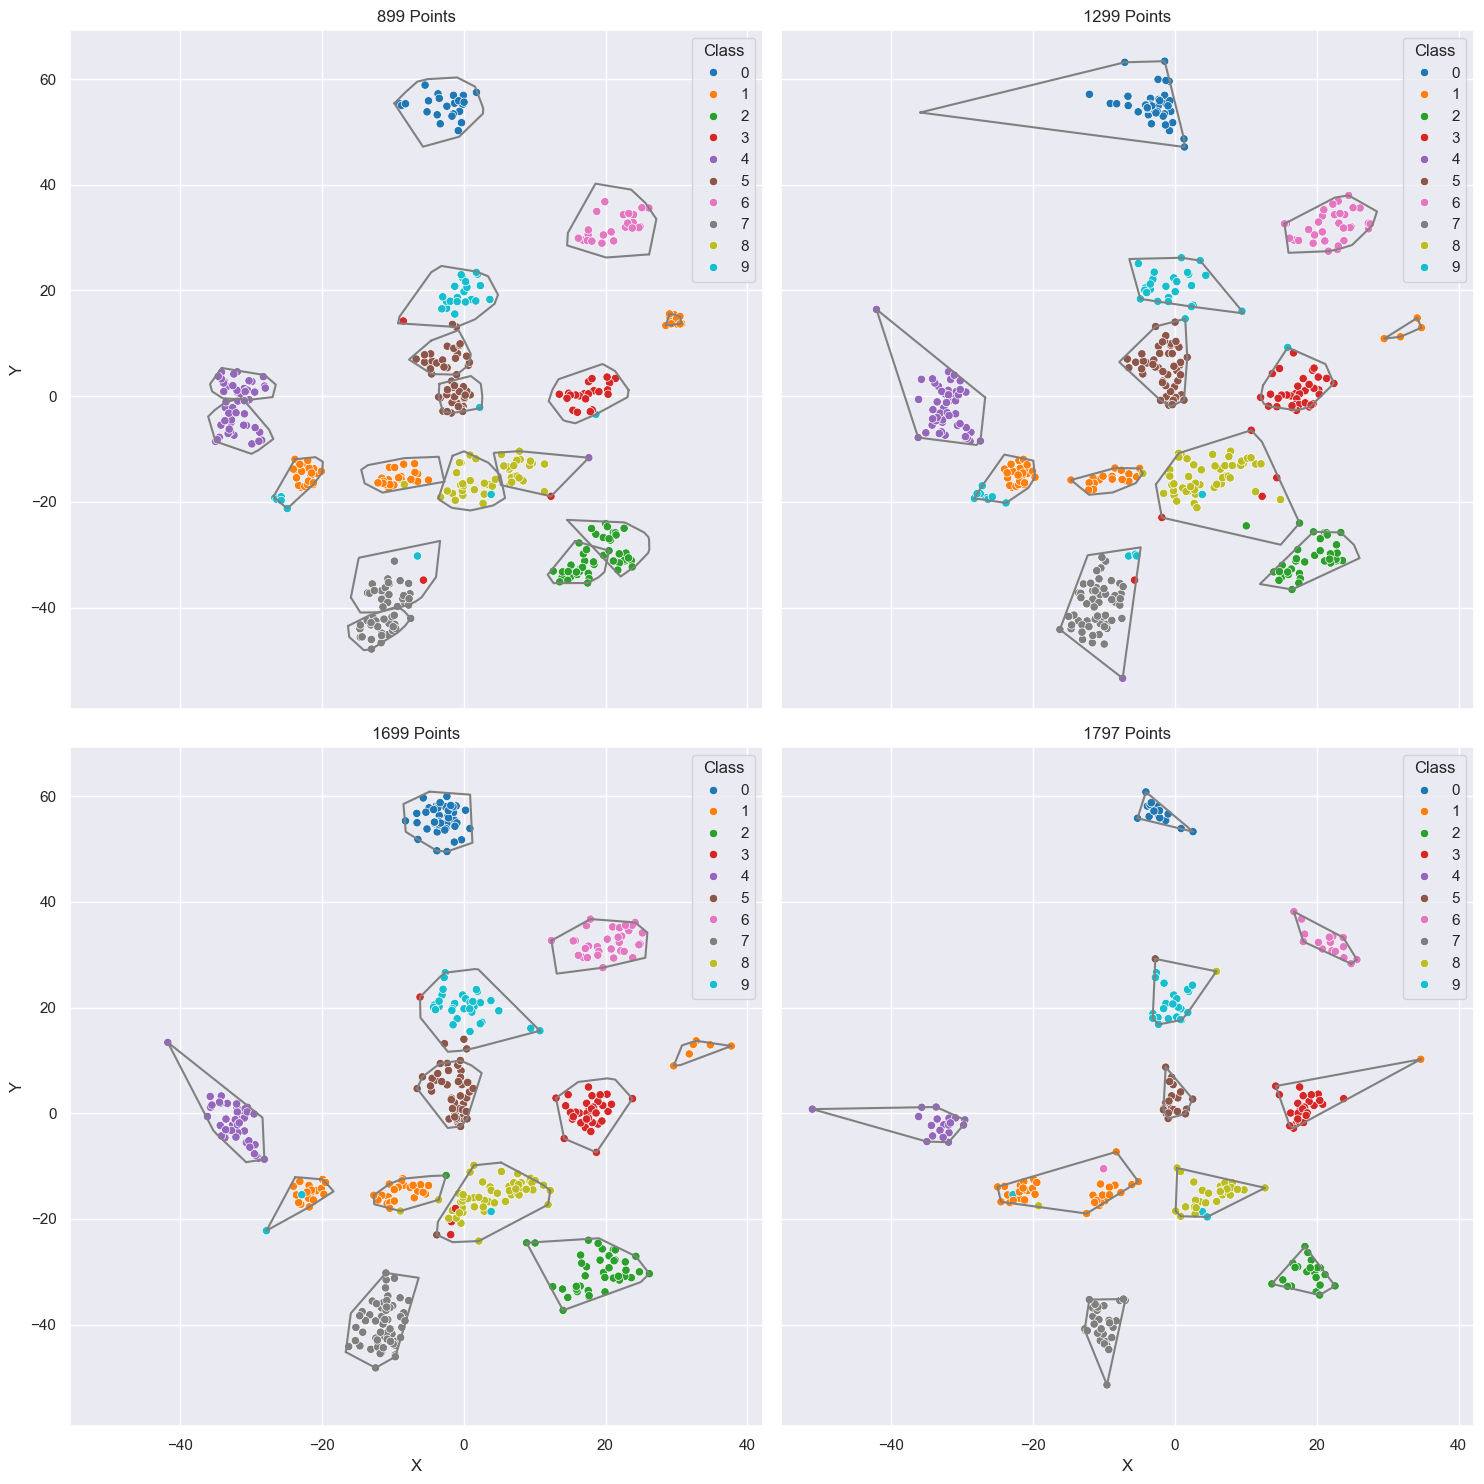

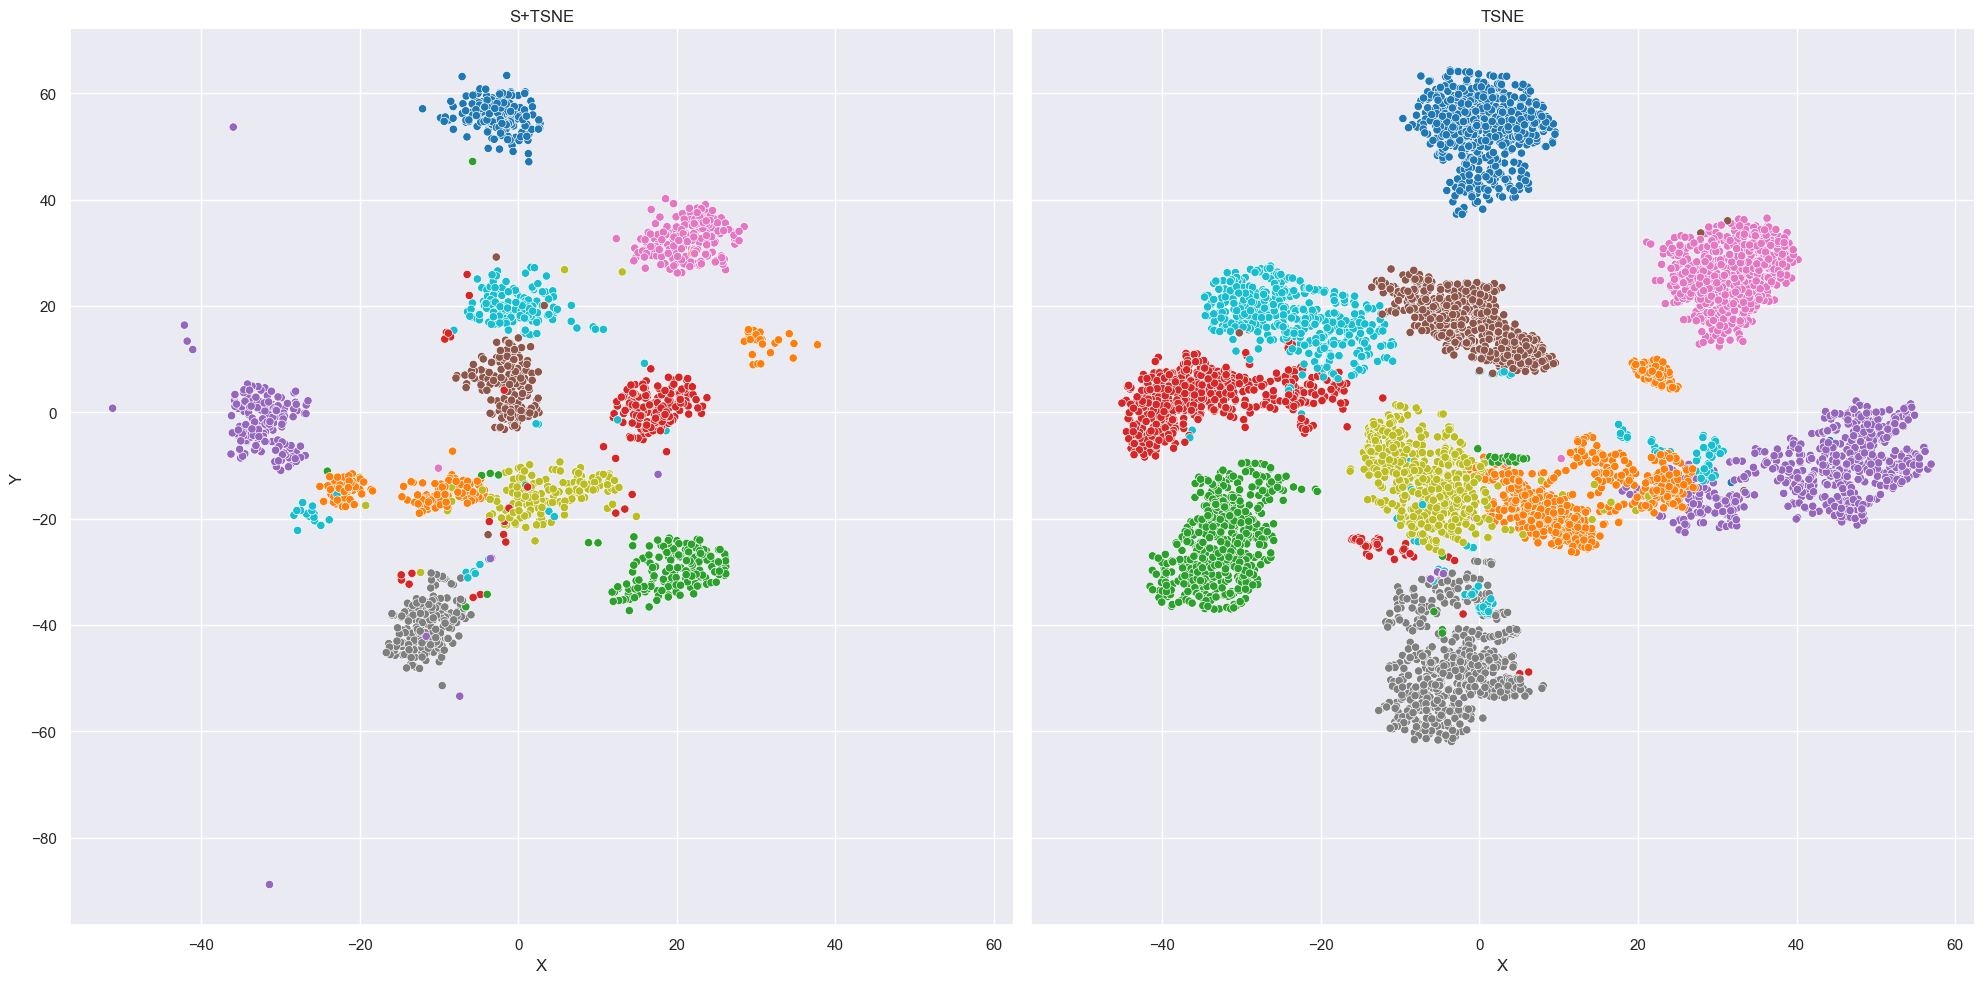

In [11]:
plot_hulls("MNIST_hulls.png",4,"MNIST",400,0.5,700,400)
plot_embeddings("MNIST_embeddings.png","MNIST",400,0.5,700,400,True)

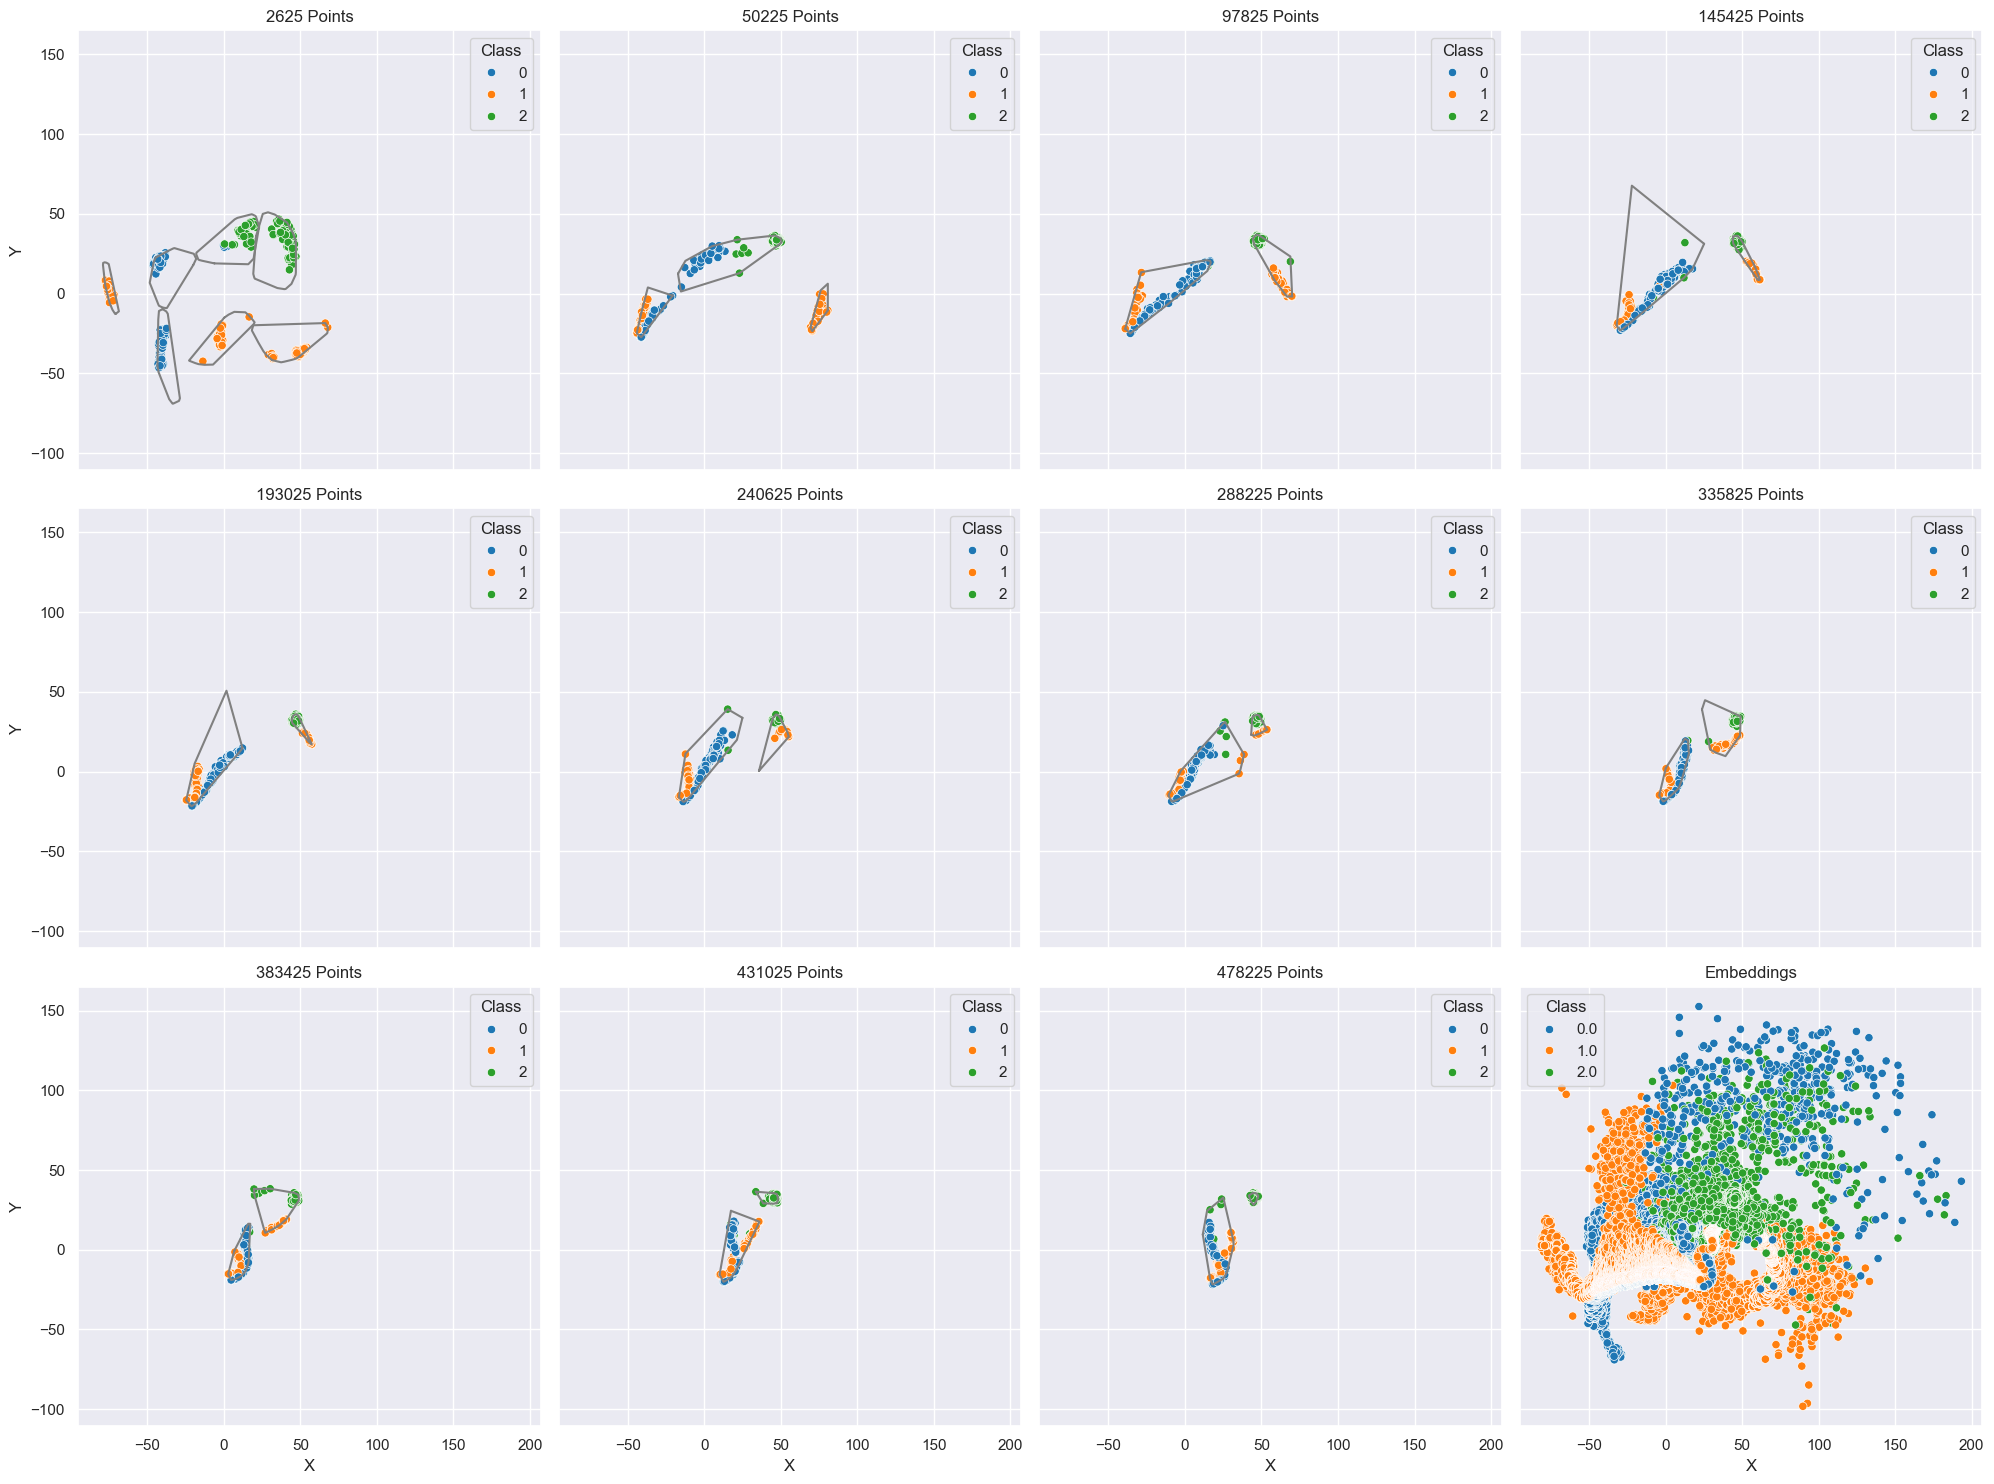

In [12]:
sns.set(font_scale=5.5)
sns.set(rc = {'figure.figsize':(20,15)})
fig,axis = plot_hulls("DRIFT_hulls.png",11,"DRIFTED_500K",400,0.005,700,400,save=False, figsize=None)
df = get_csv_by_parameters("DRIFTED_500K",400,0.005,700,400,fileNames=["embeddings"],includeOFF=False)
df = df[(df["type"]=="embeddings")]
sns.scatterplot(df,x="X",y="Y",hue="Class", palette=sns.color_palette("tab10",3), ax=axis[-1][-1])
axis[-1][-1].set_title("Embeddings")
fig.savefig("DRIFT_hulls.png")